In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [82]:
# Parameters
n = 100  # Number of points
k = 5  # Number of dimensions
noise_level = 0.5  # Standard deviation of the noise

# Generate n random points in k dimensions
torch.random.manual_seed(0)
points = torch.randn(n, k)

# Create a noise-perturbed version of the points
noise = torch.randn(n, k) * noise_level
perturbed_points = points + noise

# dadapy

In [83]:
from dadapy.metric_comparisons import MetricComparisons

In [84]:
d = MetricComparisons(points.numpy(), maxk=n - 1)

In [90]:
imbalances = d.return_information_imbalace(perturbed_points.numpy(), k=1)
imbalances[0][0], imbalances[1][0]

/tmp/ipykernel_4036891/1218422641.py:1: UserWarning: Subset size greater than the dataset size.                 Computing information imbalance once on the entire dataset.
  imbalances = d.return_information_imbalace(perturbed_points.numpy(), k=1)


(0.1794, 0.2146)

# torch rank


In [86]:
# euclidean distance


In [ ]:
def _return_ranks(dist_indices_1, dist_indices_2, k=1):
    """Finds all the ranks according to distance 2 of the neighbours according to distance 1.
       Neighbours in distance 1 are considered up to order k.

    Args:
        dist_indices_1 (np.ndarray(int)): N x maxk matrix, nearest neighbours according to distance 1
        dist_indices_2 (np.ndarray(int))): N x maxk_2 matrix, nearest neighbours according to distance 2
        k (int): order of nearest neighbour considered for the calculation of the conditional ranks, default is 1

    Returns:
        conditional_ranks (np.ndarray(int)): N x k matrix, ranks according to distance 2 of the neighbours in distance 1

    """
    assert dist_indices_1.shape[0] == dist_indices_2.shape[0]

    N = dist_indices_1.shape[0]

    conditional_ranks = np.zeros((N, k))

    for i in range(N):
        idx_k_d1 = dist_indices_1[i, 1 : k + 1]

        wr = [
            torch.where(idx_k_d1[k_neighbor] == dist_indices_2[i])[0]
            for k_neighbor in range(k)
        ]

        for k_neighbor in range(k):
            conditional_ranks[i, k_neighbor] = wr[k_neighbor][0]

    return conditional_ranks


def _return_imbal(nearest_neighbors_i, nearest_neighbors_j):
    n = len(nearest_neighbors_i)
    ranks = _return_ranks(nearest_neighbors_i, nearest_neighbors_j, k=1)
    return 2 * ranks.mean() / n


def return_information_imbalace(distance_matrix_i, distance_matrix_j):
    nearest_neighbors_i = torch.sort(distance_matrix_i, dim=1).indices

    nearest_neighbors_j = torch.sort(distance_matrix_j, dim=1).indices

    ii_ij = _return_imbal(nearest_neighbors_i, nearest_neighbors_j)
    ii_ji = _return_imbal(nearest_neighbors_j, nearest_neighbors_i)

    return ii_ij, ii_ji


distance_matrix = torch.cdist(points, points, p=2)
distance_matrix_j = torch.cdist(perturbed_points, perturbed_points, p=2)
return_information_imbalace(distance_matrix, distance_matrix_j)

(0.1794, 0.2146)

# metric comparison

In [ ]:
import pickle

fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/map_to_map/map_to_map_23_20241218.pkl"

# open pkl

with open(fname, "rb") as f:
    data = pickle.load(f)

In [159]:
import pandas as pd

metadata_df = pd.read_csv(
    "/mnt/home/gwoollard/ceph/repos/cryomethods_comparison_pipeline/osf/metadata.csv"
)
row_idx_sorted = torch.tensor(metadata_df.sort_values("pc1").index.tolist())
row_idx_sorted

tensor([3238, 3837, 3361,  ..., 3034, 3112, 3789])

<Axes: >

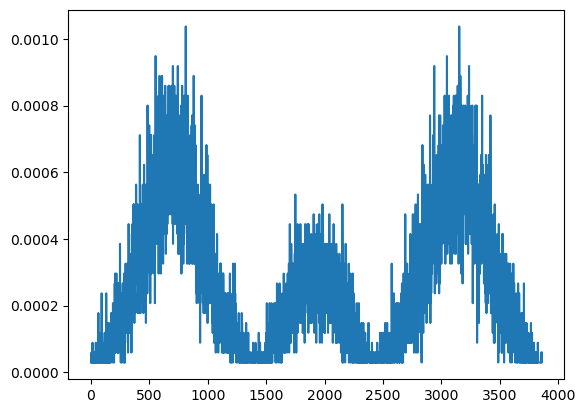

In [161]:
pd.Series(data["fsc"]["cost_matrix"].iloc[row_idx_sorted].index.tolist()).plot()

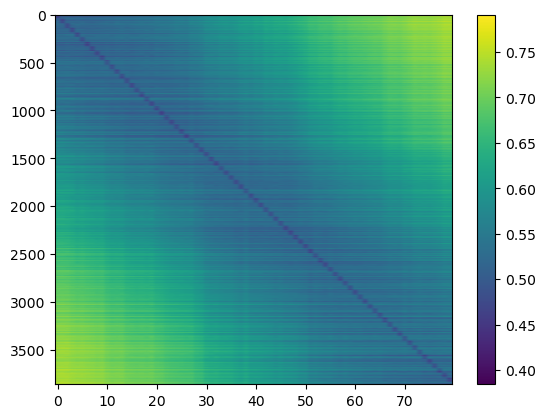

In [162]:
plt.imshow(data["fsc"]["cost_matrix"].values[row_idx_sorted], aspect="auto")
plt.colorbar()

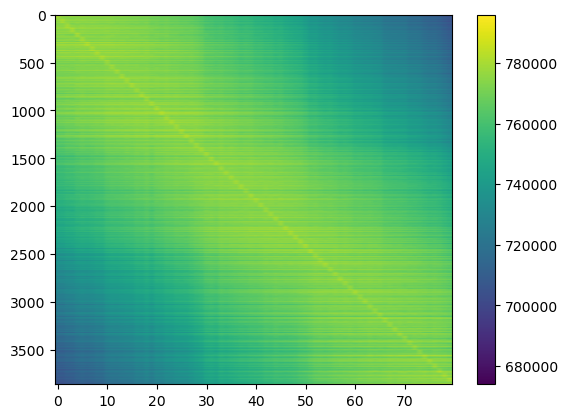

In [164]:
plt.imshow(data["corr"]["cost_matrix"].values[row_idx_sorted], aspect="auto")
plt.colorbar()

In [ ]:
distance_matrix_i = torch.from_numpy(data["fsc"]["cost_matrix"].values)
distance_matrix_j = torch.from_numpy(data["l2"]["cost_matrix"].values)

In [ ]:
from cryo_challenge._map_to_map_distance_comparison.information_imbalance import (
    return_information_imbalace,
)

distances = ["fsc", "l2", "corr", "bioem", "res"]
for distance_method_i in distances:
    distance_matrix_i = torch.from_numpy(data[distance_method_i]["cost_matrix"].values)
    if distance_matrix_i == "corr":
        distance_matrix_i *= -1

    for distance_method_j in distances:
        if distance_method_i == distance_method_j:
            continue
        distance_matrix_j = torch.from_numpy(
            data[distance_method_j]["cost_matrix"].values
        )
        if distance_matrix_j == "corr":
            distance_matrix_j *= -1

        ii = return_information_imbalace(distance_matrix_i, distance_matrix_j, k=1)
        print(distance_method_i, distance_method_j, ii)

fsc l2 (tensor(0.0010), tensor(0.0010))
fsc corr (tensor(0.0399), tensor(0.0404))
fsc bioem (tensor(0.0010), tensor(0.0010))
fsc res (tensor(0.0017), tensor(0.0019))
l2 fsc (tensor(0.0010), tensor(0.0010))
l2 corr (tensor(0.0403), tensor(0.0404))
l2 bioem (tensor(0.0005), tensor(0.0005))
l2 res (tensor(0.0018), tensor(0.0020))
corr fsc (tensor(0.0404), tensor(0.0399))
corr l2 (tensor(0.0404), tensor(0.0403))
corr bioem (tensor(0.0404), tensor(0.0403))
corr res (tensor(0.0401), tensor(0.0388))
bioem fsc (tensor(0.0010), tensor(0.0010))
bioem l2 (tensor(0.0005), tensor(0.0005))
bioem corr (tensor(0.0403), tensor(0.0404))
bioem res (tensor(0.0018), tensor(0.0020))
res fsc (tensor(0.0019), tensor(0.0017))
res l2 (tensor(0.0020), tensor(0.0018))
res corr (tensor(0.0388), tensor(0.0401))
res bioem (tensor(0.0020), tensor(0.0018))


## inspect

In [291]:
import os
import seaborn as sns
import pandas as pd

fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/metric_comparison/information_imbalance_k=10.csv"
df = pd.read_csv(fname)

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/mnt/ho

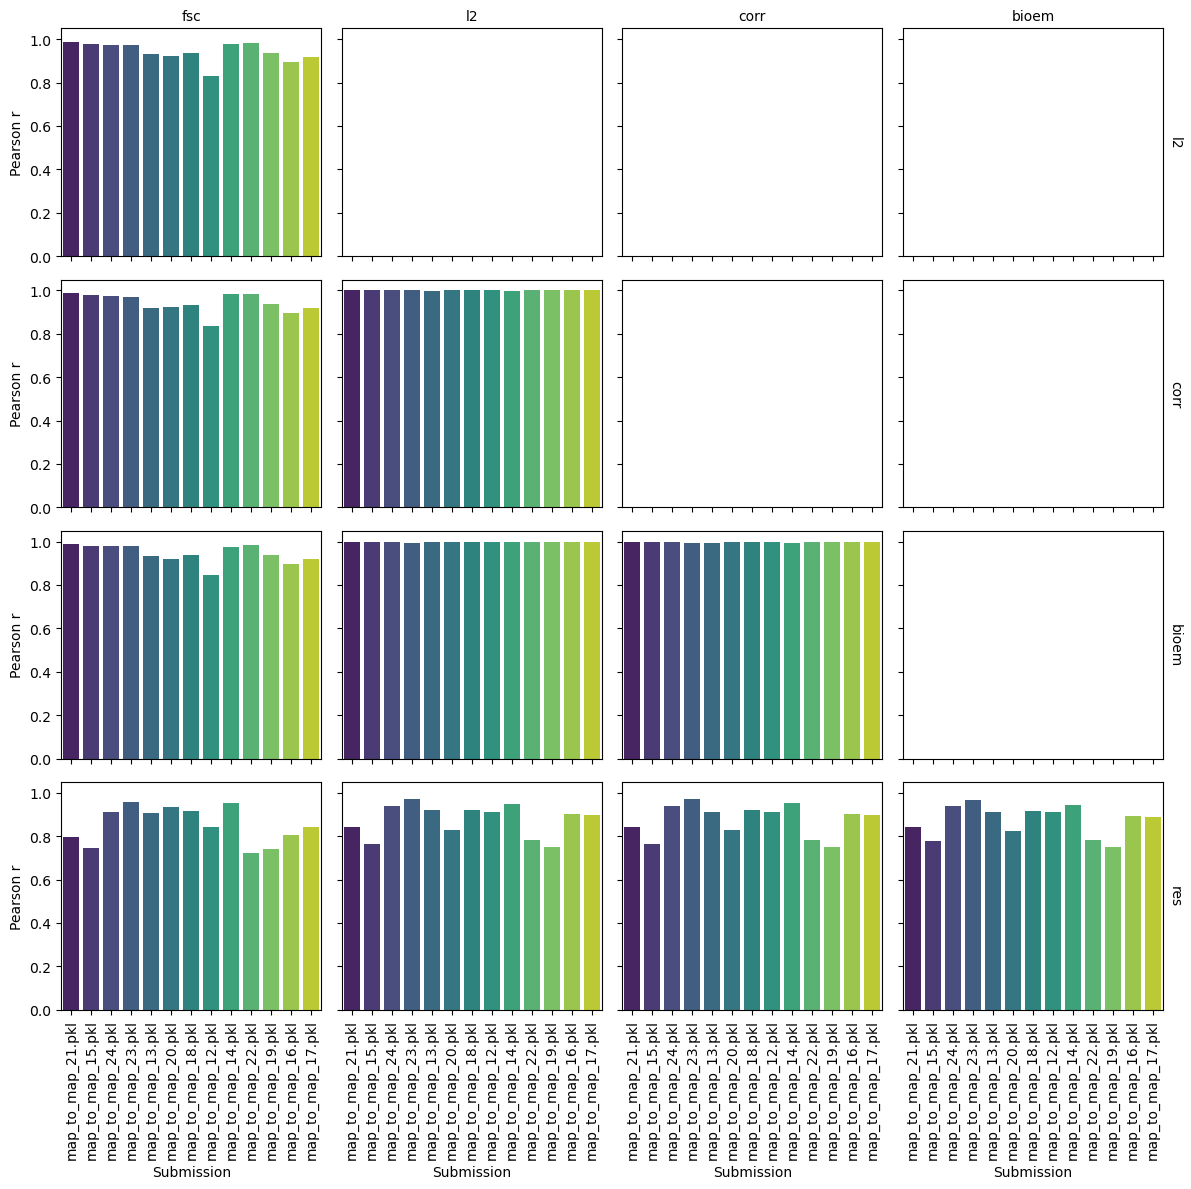

In [286]:
# Create the FacetGrid
g = sns.FacetGrid(
    df,
    col="distance_method_j",
    row="distance_method_i",
    margin_titles=True,
    despine=False,
)

# Map the barplot to the grid
g.map_dataframe(sns.barplot, x="submission", y="pearson_r", palette="viridis")

# Adjust the layout
g.set_axis_labels("Submission", "Pearson r")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Rotate x-tick labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

g.fig.tight_layout()


# Show the plot
plt.show()

In [292]:
df = pd.concat(
    [
        df,
        df.rename(
            columns={
                "distance_method_i": "distance_method_j",
                "distance_method_j": "distance_method_i",
                "ii_ij": "ii_ji",
                "ii_ji": "ii_ij",
            }
        ),
    ]
)

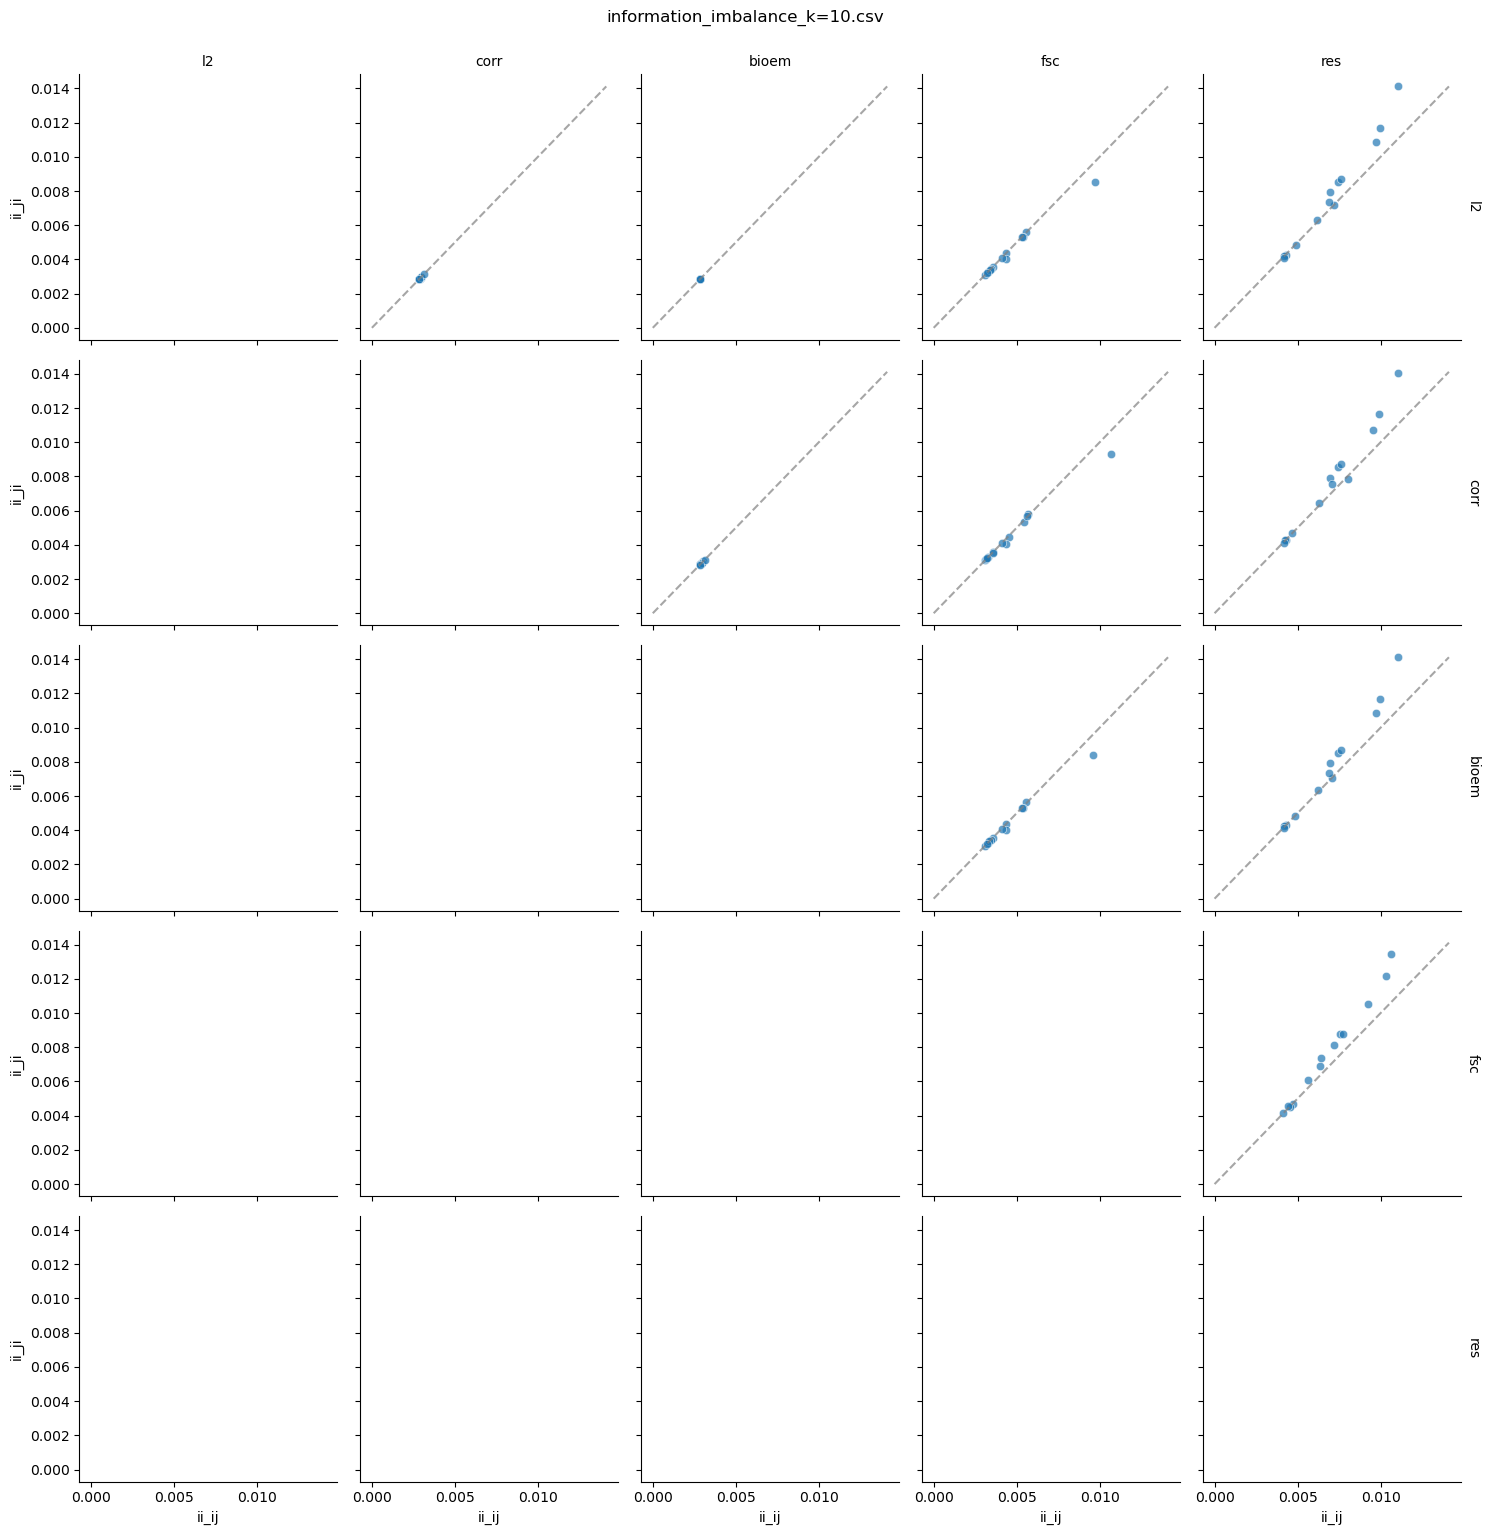

In [ ]:
# Define an order for the methods
method_order = ["l2", "corr", "bioem", "fsc", "res"]  # Adjust based on your data

# Convert to categorical type with order
df["distance_method_i"] = pd.Categorical(
    df["distance_method_i"], categories=method_order, ordered=True
)
df["distance_method_j"] = pd.Categorical(
    df["distance_method_j"], categories=method_order, ordered=True
)

# Filter to keep only upper diagonal pairs
df_upper = df[df["distance_method_i"] > df["distance_method_j"]]

# Create FacetGrid
g = sns.FacetGrid(
    df_upper, col="distance_method_i", row="distance_method_j", margin_titles=True
)

# Scatter plot
g.map_dataframe(sns.scatterplot, x="ii_ij", y="ii_ji", alpha=0.7)


# Add diagonal dashed line y = x
def add_diagonal_line(*args, **kwargs):
    ax = plt.gca()

    lims = [0, df[["ii_ij", "ii_ji"]].max().max()]  # Ensure line covers full range
    ax.plot(lims, lims, ls="--", c="gray", alpha=0.7)


g.map(add_diagonal_line)

# Adjust layout
g.set_axis_labels("ii_ij", "ii_ji")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.suptitle(os.path.basename(fname), y=1.02)
plt.show()

# mds

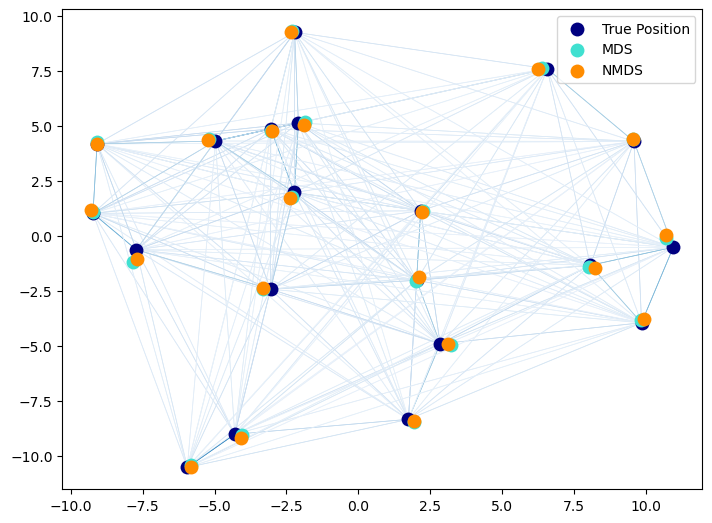

In [3]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances

EPSILON = np.finfo(np.float32).eps
n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(float)
X_true = X_true.reshape((n_samples, 2))
# Center the data
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
pos *= np.sqrt((X_true**2).sum()) / np.sqrt((pos**2).sum())
npos *= np.sqrt((X_true**2).sum()) / np.sqrt((npos**2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color="navy", s=s, lw=0, label="True Position")
plt.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [X_true[i, :], X_true[j, :]] for i in range(len(pos)) for j in range(len(pos))
]
values = np.abs(similarities)
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max())
)
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()

In [7]:
import pickle

fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/map_to_map/map_to_map_23_20241218.pkl"

# open pkl

with open(fname, "rb") as f:
    data = pickle.load(f)

similarities = -data["fsc"]["cost_matrix"].values

In [8]:
mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
)
fit = mds.fit(similarities)
fit.stress_

ValueError: array must be 2-dimensional and square. shape = (3861, 80)

In [ ]:
pos

4136834.2048164927